<a href="https://colab.research.google.com/github/ayush-dhanker/Image-Classification-on-MNIST/blob/main/model2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
from time import perf_counter
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [34]:
# normalizing and transforming
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,))
])

# Loading Datasets
train_dataset=datasets.MNIST(root='./data',train=True,download=True,transform=transform)
test_dataset=datasets.MNIST(root='./data',train=False,download=True,transform=transform)

# Data loaders
train_loader=DataLoader(train_dataset,batch_size=128,shuffle=True, drop_last=True, num_workers=2)
test_loader=DataLoader(test_dataset,batch_size=128,shuffle=False, num_workers=2)

print(int(len(train_loader.dataset)/train_loader.batch_size))

468


In [35]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# building model
model= nn.Sequential(
      nn.Flatten(),
      nn.Linear(784,512),
      nn.ReLU(),
      nn.Linear(512,128),
      nn.ReLU(),
      nn.Linear(128,10)
).to(device)

print("model = ",model)
with torch.no_grad():
    print("Maximum weight before custom init: ", model[1].weight.max())


def glorot_init(layer: nn.Module):
    if isinstance(layer, nn.Linear):
        nn.init.xavier_uniform_(layer.weight)
        nn.init.zeros_(layer.bias)


with torch.no_grad():
    model.apply(glorot_init)
    print("Maximum weight after custom init", model[1].weight.max())

Using cpu device
model =  Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=10, bias=True)
)
Maximum weight before custom init:  tensor(0.0357)
Maximum weight after custom init tensor(0.0680)


In [36]:
loss_fn=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(), lr=0.03)

In [37]:
# train_model
def train_model(
    model: nn.Module,
    loss_fn: nn.Module,
    optimizer: optim.Optimizer,
    training_loader: DataLoader,
    validation_loader: DataLoader,
    n_epochs:int,
    verbose:bool=True
    ):



  train_len=len(training_loader.dataset)
  steps_per_epoch = train_len//training_loader.batch_size

  print("Running {} epochs at {} steps per epoch ".format(n_epochs,steps_per_epoch))

  train_acc=[]
  train_loss=[]
  val_acc=[]
  val_loss=[]

  for epoch in range(n_epochs):
    if verbose:
            print("Starting epoch {}...".format(epoch + 1), end=" ")

    start_time = perf_counter()
    epoch_train_loss=[]
    epoch_train_acc=[]

    model.train()
    for batch_idx,(input_batch,label_batch) in enumerate(training_loader):
      batch_loss,batch_accuracy = training_set(input_batch,label_batch,model,loss_fn,optimizer)
      epoch_train_loss.append(batch_loss.item())
      epoch_train_acc.append(batch_accuracy.item())

    end_time = perf_counter()
    time_taken = end_time - start_time

    # evaluating
    validation_loss, val_accuracy = evaluate(model,validation_loader,loss_fn)

    val_acc.append(val_accuracy.item())
    val_loss.append(validation_loss.item())
    train_acc.append(np.mean(epoch_train_acc))
    train_loss.append(np.mean(epoch_train_loss))

    if verbose:
            print("Time taken: {} seconds".format(time_taken))
            print("\tTrain/val loss: {} / {}".format(train_loss[-1], val_loss[-1]))
            print("\tTrain/val accuracy: {} / {}".format(train_acc[-1], val_acc[-1]))

  return {"train_loss": np.array(train_loss), "train_acc": np.array(train_acc),
            "val_loss": np.array(val_loss), "val_acc": np.array(val_acc)}


def training_set(
      input: torch.tensor,
      label: torch.tensor,
      model: nn.Module,
      loss_fn: nn.Module,
      optimizer: optim.Optimizer):

    input=input.to(device)
    label=label.to(device)
    output_batch=model(input)
    loss_batch=loss_fn(output_batch, label)

    loss_batch.backward()
    optimizer.step()
    optimizer.zero_grad()

    with torch.no_grad():
      batch_acc=accuracy(label,output_batch)
    # see loss_batch.item()
    return loss_batch, batch_acc


def evaluate(
      model:nn.Module,
      dataloader:DataLoader,
      loss_fn:nn.Module):
    model.eval()
    size=len(dataloader.dataset)
    num_batches=len(dataloader)
    loss,correct=0,0

    with torch.no_grad():
      for input,label in dataloader:
        input=input.to(device)
        label=label.to(device)
        prediction=model(input)
        loss+=loss_fn(prediction,label)
        correct += (prediction.argmax(axis=1)==label).type(torch.float).sum()

    loss/=num_batches
    val_accuracy=correct/size
    return loss, val_accuracy

def accuracy(labels:torch.tensor,
               outputs:torch.tensor)->torch.tensor:
               predictions=torch.argmax(outputs,axis=-1)
               matches=labels==predictions
               return matches.float().mean()

In [38]:
metrics = train_model(model, loss_fn, optimizer, train_loader, test_loader, n_epochs=25)

Running 25 epochs at 468 steps per epoch 
Starting epoch 1... Time taken: 18.685547142000132 seconds
	Train/val loss: 0.35208310355615413 / 0.20009829103946686
	Train/val accuracy: 0.9000567574786325 / 0.9433000087738037
Starting epoch 2... Time taken: 17.111209690000123 seconds
	Train/val loss: 0.17585891127809244 / 0.14923062920570374
	Train/val accuracy: 0.9498364049145299 / 0.9574000239372253
Starting epoch 3... Time taken: 18.251621425000167 seconds
	Train/val loss: 0.13279895920656684 / 0.12321174889802933
	Train/val accuracy: 0.9629573985042735 / 0.963699996471405
Starting epoch 4... Time taken: 17.06309150700008 seconds
	Train/val loss: 0.106098577611021 / 0.11265706270933151
	Train/val accuracy: 0.9705695779914529 / 0.9660999774932861
Starting epoch 5... Time taken: 18.630344487000002 seconds
	Train/val loss: 0.08838690444031078 / 0.09828490763902664
	Train/val accuracy: 0.9754941239316239 / 0.9700000286102295
Starting epoch 6... Time taken: 17.026212357000077 seconds
	Train/v

In [39]:
print(metrics)

{'train_loss': array([0.3520831 , 0.17585891, 0.13279896, 0.10609858, 0.0883869 ,
       0.07519216, 0.06434654, 0.05591025, 0.04890874, 0.04304076,
       0.03780065, 0.03334006, 0.02975578, 0.02666654, 0.0235486 ,
       0.02109362, 0.01881389, 0.01678628, 0.0151911 , 0.01360693,
       0.01225997, 0.01101638, 0.01024238, 0.0091456 , 0.00840674]), 'train_acc': array([0.90005676, 0.9498364 , 0.9629574 , 0.97056958, 0.97549412,
       0.97896635, 0.9826222 , 0.98534322, 0.98731303, 0.98881544,
       0.99083534, 0.99235443, 0.99312233, 0.99425748, 0.99527577,
       0.99601028, 0.99684495, 0.99742922, 0.99769631, 0.99821381,
       0.99864784, 0.99891493, 0.99903178, 0.99928218, 0.99948251]), 'val_loss': array([0.20009829, 0.14923063, 0.12321175, 0.11265706, 0.09828491,
       0.09167585, 0.08905271, 0.08113942, 0.07782355, 0.07410999,
       0.0728049 , 0.07022554, 0.0717025 , 0.0689493 , 0.06624586,
       0.06953384, 0.06643227, 0.06428716, 0.06467733, 0.06510315,
       0.06348968,

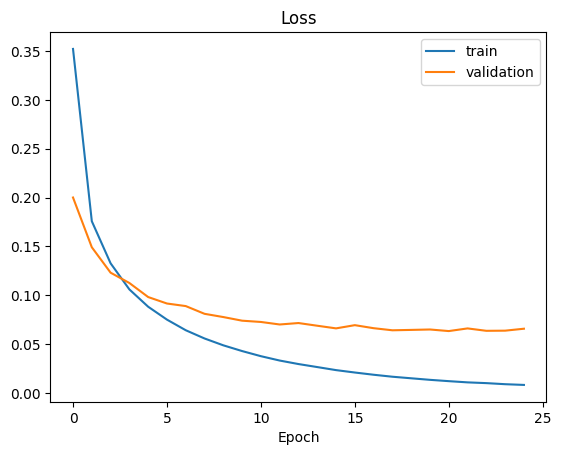

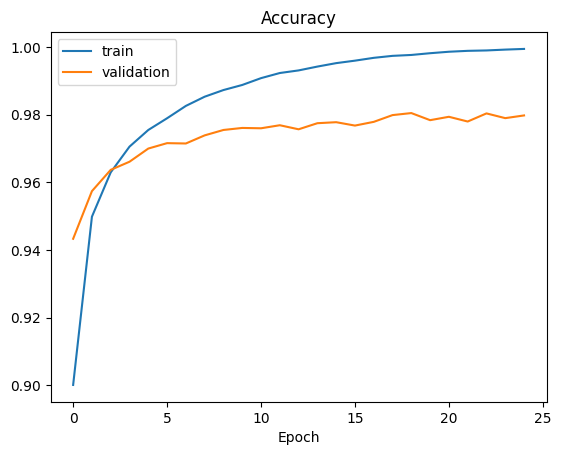

In [40]:
# visualization
plt.plot(metrics["train_loss"], label="train")
plt.plot(metrics["val_loss"], label="validation")
plt.legend()
plt.title("Loss")
plt.xlabel("Epoch")
plt.show()

print('\n')

plt.plot(metrics["train_acc"], label="train")
plt.plot(metrics["val_acc"], label="validation")
plt.legend()
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.show()

### 1. Loss Graph
- Validation loss stops decreasing while training loss continues to drop after **epoch 10–12**.
- **Overfitting** may be happening.

**Solution:**  
- Use **Early Stopping** or apply **Regularization Techniques** (e.g., dropout, L2 regularization).

---

### 2. Accuracy Graph
- Training accuracy reaches **100%**, indicating the model is **overfitting**.
- Validation accuracy remains high at around **98%**, showing the model still generalizes fairly well.
